In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('ggplot')
from matplotlib.colors import ListedColormap
import seaborn as sns

import re
import os
import pickle
from glob import glob
from preprocess_drone import preprocess, create_time_series_features

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Logistic Regression
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
# Support Vector Machine
from sklearn.svm import SVC
# Decision Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
# XGBoost (requires xgboost package)
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, GroupKFold, learning_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
def get_file_paths(directory, extensions=['.csv', '.CSV', '.xlsx']):
    file_paths = []
    # Iterate over each extension
    for ext in extensions:
        # Use glob to find all files with the given extension in the directory and subdirectories
        file_paths.extend(glob(os.path.join(directory, '**', f'*{ext}'), recursive=True))
    return file_paths

In [3]:
# Specify the root directory
root_directory = os.path.join('logs', 'selected', '1')

# Get the list of file paths
file_paths_normal = get_file_paths(root_directory)
print(f'Found {len(file_paths_normal)} normal log files.')

Found 116 normal log files.


In [4]:
# Specify the root directory
root_directory = os.path.join('logs', 'selected', '-1')

# Get the list of file paths
file_paths_non_normal = get_file_paths(root_directory)
print(f'Found {len(file_paths_non_normal)} non-normal log files.')

Found 97 non-normal log files.


In [5]:
time_series_data = np.empty((0, 23))
labels = []
flight_id_map = {}
i = 0
data_column_names = None

for idx, x in enumerate(file_paths_normal + file_paths_non_normal) :
    # if len(time_series_data) >= 200 :
    #     break
    if x.lower().endswith('.csv') :
        df = preprocess(pd.read_csv(x))
    else :
        df = preprocess(pd.read_excel(x))
    if df is not None:
        # file_paths_considered.append(x)
        flight_id_map[x] = i
        df['flightId'] = i
        i += 1
        
        df = create_time_series_features(df)
        data_column_names = list(df.columns)
        
        label = 0 if idx < len(file_paths_normal) else 1
        labels.extend([label] * len(df))
        time_series_data = np.concatenate((time_series_data, df.values), axis=0)

In [6]:
time_series_data.shape

(728606, 23)

In [7]:
labels = np.array(labels)
labels.shape

(728606,)

In [8]:
data_column_names

['Motor Speed (RPM)',
 'Engine Speed (RPM)',
 'Throttle (%)',
 'Intake Temperature (C)',
 'Engine Coolant Temperature 1 (C)',
 'Engine Coolant Temperature 2 (C)',
 'Barometric Pressure (kpa)',
 'Fuel Trim',
 'Fuel Consumption (g/min)',
 'Fuel Consumed (g)',
 'Bus Voltage (V)',
 'Battery Current (A)',
 'Power Generated (W)',
 'Inverter Temperature (C)',
 'Target Fuel Pressure (bar)',
 'Fuel Pressure (bar)',
 'Fuel Pump Speed (RPM)',
 'Cooling Pump Speed (RPM)',
 'flightId',
 'hour',
 'minute',
 'second',
 'microsecond']

In [9]:
# Define column indices for PCA
pca_column_indices = list(range(0, 18))
pca_column_indices.remove(2) # Indices for the columns from 'Motor Speed (RPM)' to 'Cooling Pump Speed (RPM)'

# Column index to scale using MinMaxScaler
throttle_column_indices = [2]  # Index for 'Throttle (%)'

# Columns to keep unchanged (by indices)
unchanged_column_indices = list(range(18, 23))  # Indices for 'flightId', 'hour', 'minute', 'second', 'microsecond'

In [10]:
# Define the transformers
pca_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

minmax_scaler = MinMaxScaler()

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('pca', pca_transformer, pca_column_indices),
        ('throttle', minmax_scaler, throttle_column_indices)
    ],
    remainder='passthrough'  # This will keep the unchanged columns
)

# Fit and transform the data using the preprocessor
transformed_data = preprocessor.fit_transform(time_series_data)

# Convert the transformed data back to a DataFrame for better readability
# The output column names after PCA will be 'PC1', 'PC2', ..., 'PCn' where n is the number of components
pca_feature_names = [f'PC{i+1}' for i in range(transformed_data.shape[1] - len(unchanged_column_indices) - 1)]
final_column_names = pca_feature_names + ['Throttle (%)'] + [data_column_names[i] for i in unchanged_column_indices]

final_df = pd.DataFrame(transformed_data, columns=final_column_names)
final_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Throttle (%),flightId,hour,minute,second,microsecond
0,3.359371,6.809563,-1.434783,2.436206,7.550397,-8.755447,0.832496,-1.157221,2.608039,-0.903789,0.00,0.0,0.0,0.0,2.0,540000.0
1,3.414792,6.807519,-1.424025,2.431154,7.557553,-8.741022,0.847700,-1.154323,2.574772,-0.852412,0.00,0.0,0.0,0.0,2.0,790000.0
2,3.400833,6.631217,-1.386838,2.448675,7.709781,-8.772546,0.802014,-1.253002,2.467058,-0.886149,0.00,0.0,0.0,0.0,3.0,40000.0
3,3.344064,6.633288,-1.397780,2.453765,7.702495,-8.787401,0.786385,-1.255806,2.501563,-0.938903,0.00,0.0,0.0,0.0,3.0,290000.0
4,3.344064,6.633288,-1.397780,2.453765,7.702495,-8.787401,0.786385,-1.255806,2.501563,-0.938903,0.00,0.0,0.0,0.0,3.0,540000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728601,0.075765,-0.550697,2.145582,-1.069273,0.781592,-0.110081,1.576429,-1.152851,-0.422152,1.257424,0.05,212.0,0.0,43.0,39.0,290000.0
728602,0.073991,-0.551312,2.142751,-1.071213,0.782267,-0.110532,1.577659,-1.152268,-0.421355,1.255956,0.05,212.0,0.0,43.0,39.0,540000.0
728603,0.075114,-0.551014,2.144216,-1.070267,0.781961,-0.110247,1.577110,-1.152546,-0.421883,1.256904,0.05,212.0,0.0,43.0,39.0,790000.0
728604,0.071838,-0.553622,2.133464,-1.078255,0.785056,-0.111037,1.583142,-1.150101,-0.421272,1.254676,0.05,212.0,0.0,43.0,40.0,40000.0


In [11]:
pd.Series(labels).value_counts()

1    408008
0    320598
Name: count, dtype: int64

In [12]:
flight_ids = final_df['flightId']
X = final_df.drop('flightId', axis=1)  # Drop 'flightId' for model training
y = labels

# Initialize GroupKFold
group_kfold = GroupKFold(n_splits=5)  # Adjust n_splits as needed

In [19]:
# Models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, n_jobs=-1),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Support Vector Machine': SVC(max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_iter_no_change=100),
    # 'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(n_jobs=-1),
    # 'LightGBM': lgb.LGBMClassifier(),
    # 'CatBoost': CatBoostClassifier(learning_rate=0.1, iterations=100, depth=6),
    # 'Gaussian Naive Bayes': GaussianNB(),
    # 'Multinomial Naive Bayes': MultinomialNB(),
    # 'Bernoulli Naive Bayes': BernoulliNB(),
    # 'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
    # 'MLP Classifier': MLPClassifier(max_iter=10000, n_iter_no_change=100),
    # 'Ridge Classifier': RidgeClassifier(),
    # 'Perceptron': Perceptron(max_iter=10000)
}

# Initialize DataFrame to store results
results_df = pd.DataFrame(dtype=np.float64)


In [20]:
# Train-Test Split and Evaluation
for model_name, model in models.items():
    print(f"Testing model: {model_name}")
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    for fold, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups=flight_ids), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1_scores.append(f1)
        
        print(f'Fold: {fold}, acc: {accuracy}')
        
    mean_accuracy = np.mean(fold_accuracies)
    mean_precision = np.mean(fold_precisions)
    mean_recall = np.mean(fold_recalls)
    mean_f1_score = np.mean(fold_f1_scores)
    
    
    # Store results
    results_df.loc[model_name, ['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score']] = [
        mean_accuracy,
        mean_precision,
        mean_recall,
        mean_f1_score
    ]

Testing model: Logistic Regression
Fold: 1, acc: 0.799275332482398
Fold: 2, acc: 0.8636856480147129
Fold: 3, acc: 0.8506608473669041
Fold: 4, acc: 0.8398652218966381
Fold: 5, acc: 0.8126668450922666
Testing model: Decision Tree
Fold: 1, acc: 0.9993206242022481
Fold: 2, acc: 0.9998764771276815
Fold: 3, acc: 1.0
Fold: 4, acc: 1.0
Fold: 5, acc: 0.9228515155882212
Testing model: Random Forest
Fold: 1, acc: 0.9959168828316932
Fold: 2, acc: 0.999986275236409
Fold: 3, acc: 1.0
Fold: 4, acc: 1.0
Fold: 5, acc: 0.8664690260021
Testing model: Gradient Boosting
Fold: 1, acc: 0.9402217921796298
Fold: 2, acc: 0.9627372668505785
Fold: 3, acc: 0.9821166330409958
Fold: 4, acc: 0.9895485208034531
Fold: 5, acc: 0.9246700842031581
Testing model: XGBoost
Fold: 1, acc: 0.983104816019544
Fold: 2, acc: 1.0
Fold: 3, acc: 1.0
Fold: 4, acc: 1.0
Fold: 5, acc: 0.9911885203713997


In [31]:
results_df.index.name = 'Model'

In [32]:
results_df.sort_values(by=['Mean Accuracy', 'Mean F1 Score', 'Mean Precision', 'Mean Recall'], ascending=False)

,Mean Accuracy,Mean Precision,Mean Recall,Mean F1 Score
Model,,,,
XGBoost,0.994859,0.991889,0.991889,0.995899
Decision Tree,0.984410,0.974916,0.974916,0.986637
Random Forest,0.972474,0.955765,0.955765,0.975297
Gradient Boosting,0.959859,0.941866,0.941866,0.963821
Logistic Regression,0.833231,0.824376,0.824376,0.845632


<Axes: xlabel='Model'>

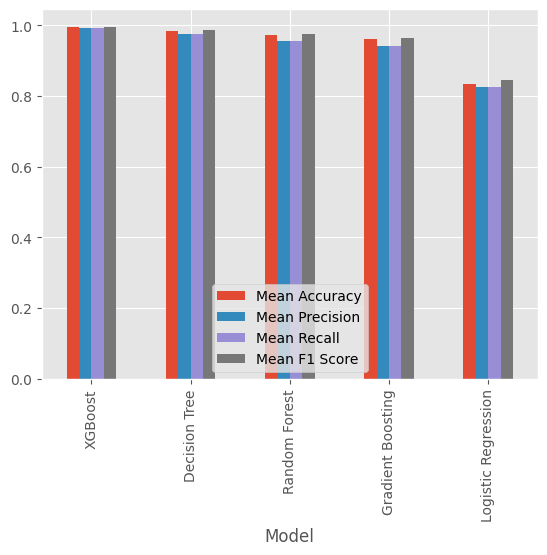

In [33]:
results_df.sort_values(by=['Mean Accuracy', 'Mean F1 Score', 'Mean Precision', 'Mean Recall'], ascending=False).plot(kind='bar')

In [71]:
grouped.size().iloc[:2].sum()

2957

In [62]:
for idx, val in grouped.size().items() :
    print(idx, val)
    break

0.0 2897


In [13]:
grouped = final_df.groupby('flightId')

# Extract unique flight IDs
flight_ids = grouped.groups.keys()

# Split flight IDs into train and test sets
train_flight_ids, test_flight_ids = train_test_split(list(flight_ids), test_size=0.2, random_state=42)

# Create boolean masks for training and testing sets
train_mask = final_df['flightId'].isin(train_flight_ids)
test_mask = final_df['flightId'].isin(test_flight_ids)

# Apply masks to split the data
X_train = final_df[train_mask].drop('flightId', axis=1) 
y_train = labels[train_mask]

X_test = final_df[test_mask].drop('flightId', axis=1)
y_test = labels[test_mask]

print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')

X_train shape: (599911, 15)
X_test shape: (128695, 15)


In [44]:
# Define and train the voting classifier
voting_clf = VotingClassifier(estimators=[
    ('logistic', LogisticRegression(max_iter=10000, n_jobs=-1)),
    ('tree', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier(n_iter_no_change=100)),
    ('xgb', XGBClassifier(n_jobs=-1))
], voting='hard')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=10000, n_jobs=-1)),
                             ('tree', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier()),
                             ('gb',
                              GradientBoostingClassifier(n_iter_no_change=100)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=No...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [53]:
pickle_file = os.path.join("FinalModel",  "drone_troopers", "models", "voting_classifier_model.pkl")
with open(pickle_file, 'wb') as file:
    pickle.dump(voting_clf, file)

In [52]:
with open(os.path.join("FinalModel", "drone_troopers", "models", "preprocessor.pkl"), "wb") as file:
    pickle.dump(preprocessor, file)

In [54]:
with open(os.path.join("FinalModel", "drone_troopers", "models", "data_column_names.pkl"), "wb") as file:
    pickle.dump(data_column_names, file)

In [48]:
# Evaluate
y_pred = voting_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy score of final model: {accuracy:.3f}')
print(f'Precision score of final model: {precision:.3f}')
print(f'Recall score of final model: {recall:.3f}')
print(f'F1 score of final model: {f1:.3f}')

Accuracy score of final model: 1.000
Precision score of final model: 1.000
Recall score of final model: 1.000
F1 score of final model: 1.000


In [78]:
voting_clf.estimators_[1]

DecisionTreeClassifier()

In [82]:
# Extract the trained DecisionTreeClassifier
tree_clf = [clf for name, clf in voting_clf.estimators if isinstance(clf, DecisionTreeClassifier)][0]
tree_clf = voting_clf.estimators_[1]
# Visualize the Decision Tree
plt.figure(figsize=(22, 10))
plot_tree(tree_clf, filled=True, feature_names=X_train.columns, class_names=['Normal', 'Not Normal'],)
plt.title('Decision Tree Visualization')
# Save with high resolution
plt.savefig('decision_tree_high_res.svg', dpi=300)  # Adjust dpi as needed
plt.close()

In [89]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black', cbar=False,
                annot_kws={"size": 16}, vmin=0, vmax=np.max(cm_df.values) + 1)
    
    # Set the labels and title
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.title(title, fontsize=16)
    
    plt.show()


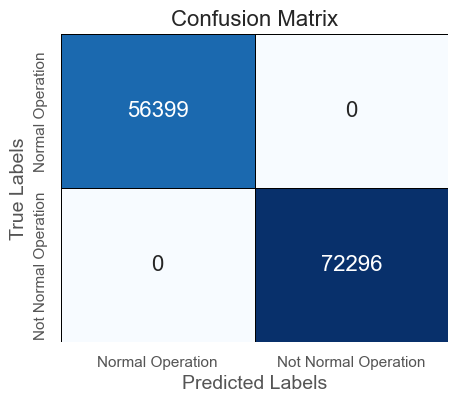

In [90]:
class_names = ['Normal Operation', 'Not Normal Operation']
plot_confusion_matrix(y_test, y_pred, class_names)

In [140]:
def plot_feature_importances(clf, feature_names):
    # Aggregate feature importances from individual models
    importances = np.mean([est.feature_importances_ for name, est in zip(list(dict(clf.estimators).keys()), clf.estimators_) if hasattr(est, 'feature_importances_')], axis=0)
    
    # Create a DataFrame for easier plotting
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.savefig('feature_importances.png', dpi=300)
    plt.show()


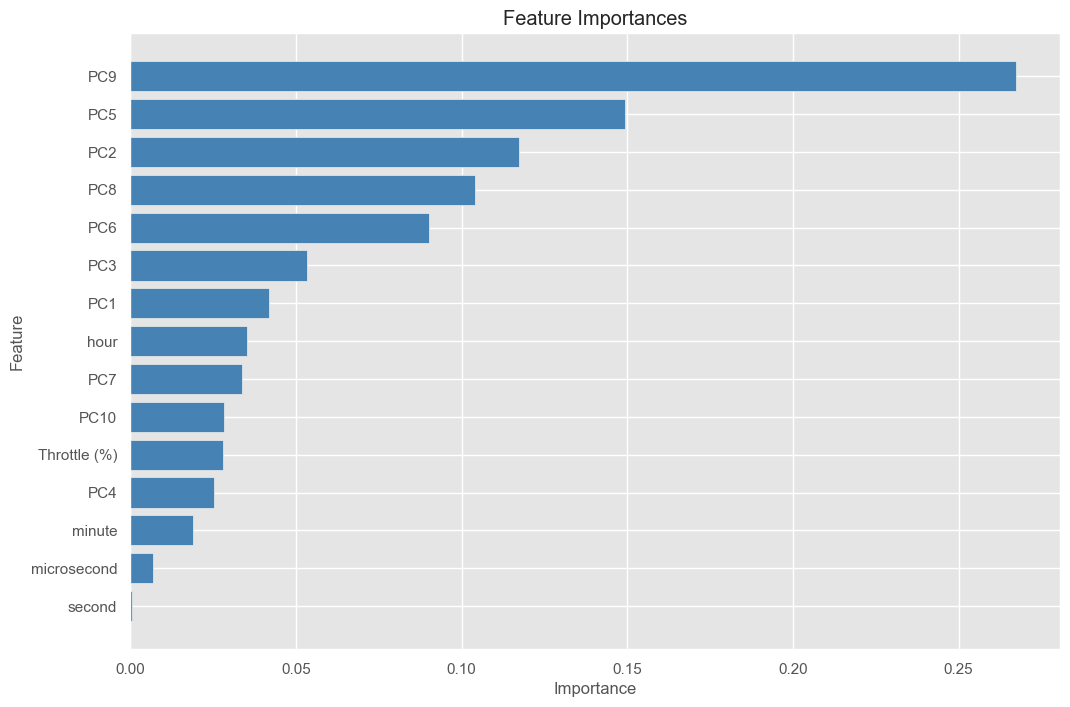

In [141]:
plot_feature_importances(voting_clf, X.columns)

In [179]:
test_df = preprocess(pd.read_excel(os.path.join('logs', 'selected', '-1', '50 throttle not enough power(annotated).xlsx')))
test_df['flightId'] = 400

test_df = create_time_series_features(test_df)

label = [0] * len(test_df)
transformed_data = preprocessor.transform(test_df.values)
# Convert the transformed data back to a DataFrame for better readability
# The output column names after PCA will be 'PC1', 'PC2', ..., 'PCn' where n is the number of components
pca_feature_names = [f'PC{i+1}' for i in range(transformed_data.shape[1] - len(unchanged_column_indices) - 1)]
final_column_names = pca_feature_names + ['Throttle (%)'] + [data_column_names[i] for i in unchanged_column_indices]

final_df = pd.DataFrame(transformed_data, columns=final_column_names)
final_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Throttle (%),flightId,hour,minute,second,microsecond
0,2.536691,-0.295954,0.837338,-0.536785,0.295978,0.518618,1.108779,-1.498604,-1.677554,0.221319,0.05,400.0,0.0,0.0,4.0,40000.0
1,2.493653,-0.293313,0.832776,-0.529727,0.289112,0.507472,1.094380,-1.501954,-1.651556,0.181219,0.05,400.0,0.0,0.0,4.0,300000.0
2,2.466910,-0.292362,0.827535,-0.527279,0.285614,0.500432,1.087063,-1.503264,-1.635229,0.156351,0.05,400.0,0.0,0.0,4.0,540000.0
3,2.431239,-0.290660,0.821870,-0.522946,0.280581,0.491258,1.076428,-1.505637,-1.614160,0.123331,0.05,400.0,0.0,0.0,4.0,800000.0
4,2.403821,-0.289343,0.817911,-0.519526,0.276655,0.483997,1.067966,-1.507160,-1.596913,0.097630,0.05,400.0,0.0,0.0,5.0,40000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10461,0.075765,-0.550697,2.145582,-1.069273,0.781592,-0.110081,1.576429,-1.152851,-0.422152,1.257424,0.05,400.0,0.0,43.0,39.0,290000.0
10462,0.073991,-0.551312,2.142751,-1.071213,0.782267,-0.110532,1.577659,-1.152268,-0.421355,1.255956,0.05,400.0,0.0,43.0,39.0,540000.0
10463,0.075114,-0.551014,2.144216,-1.070267,0.781961,-0.110247,1.577110,-1.152546,-0.421883,1.256904,0.05,400.0,0.0,43.0,39.0,790000.0
10464,0.071838,-0.553622,2.133464,-1.078255,0.785056,-0.111037,1.583142,-1.150101,-0.421272,1.254676,0.05,400.0,0.0,43.0,40.0,40000.0


In [180]:
np.unique(model.predict(final_df.drop(columns=['flightId'])))

array([1])